# Prototipo GNN: Búsqueda de Camino Más Corto
## Training and Testing

### Librerías


In [1]:
# -*- coding: utf-8 -*-
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/GNN')

!pip uninstall -y tensorflow 
!pip install "tensorflow>=1.15,<2"
!pip install graph_nets "dm-sonnet<2" "tensorflow_probability<0.9"
!apt install --allow-change-held-packages libcudnn7=7.4.1.5-1+cuda10.0
#%tensorflow_version 1.x  # For Google Colab only.

Mounted at /content/drive
Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110.5 MB 1.7 kB/s 
     |████████████████████████████████| 503 kB 72.9 MB/s 
     |████████████████████████████████| 20.1 MB 88.1 MB/s 
     |████████████████████████████████| 3.8 MB 58.5 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 2.9 MB 65.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=8e04f95d733a2590de362558f8d41837afb82c96571e3144da871cc93040aa53
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 2.1 MB/s 
     |████████████████████████████████| 665 kB 33.2 MB/s 
     |████████████████████████████████| 2.5 MB 71.6 MB/s 
  Created wheel for graph-nets: filename=graph_nets-1.1.0-py3-none-any.whl size=91857 sha256=7c37e8e8b0af4db40b640d432da10b4827288036629a1b09d7e1308cde033bfe
  Stored in directory: /root/.cache/pip/wheels/44/3d/65/f2e8f0a8d0b28bea5f168fc717261a67303d2183a3e450c812
Successfully built graph-nets
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.5.0
    Uninstalling cloudpickle-1.5.0:
      Successfully uninstalled cloudpickle-1.5.0
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.16.0
    Uninstalling tensorflow-probability-0.16.0:
      Successfully uninstalled tensorflow-probability-0.16.0
ERROR: pip's dependency resolver does not c

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Debug
import pdb

# Miscelaneas
#%matplotlib widget
import sys
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import collections
import pickle
import time

# Graph nets
from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from gnn_lib import models_tunned as models
from graph_nets.graphs import GraphsTuple
import tensorflow as tf

# Py cgr
from py_cgr_lib.py_cgr_lib import Contact
from py_cgr_lib.py_cgr_lib import cgr_dijkstra
from py_cgr_lib.py_cgr_lib import cp_load_from_list

# Helper functions
from gnn_lib.gnn_lib import *


# Inicializacion del generador de numeros aleatorios
SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)
rand = np.random.RandomState(seed=SEED)

# Desactivo la representacion cientifica de numpy
np.set_printoptions(suppress=True)

### Funciones especificas


In [3]:
class Dataset():
  def __init__(self, datasetName, BatchSize_train, TotalNumBatch_train, NumBatchFile_train, BatchSize_test, TotalNumBatch_test, NumBatchFile_test):
    
    self.BatchSize_train = BatchSize_train
    self.TotalNumBatch_train = TotalNumBatch_train
    self.NumBatchFile_train  = NumBatchFile_train
    
    self.BatchSize_test = BatchSize_test
    self.TotalNumBatch_test = TotalNumBatch_test
    self.NumBatchFile_test   = NumBatchFile_test

    self.path_Dataset_inputGraphs_train_i  = "Datasets/" + datasetName + "_Train_InputGraphs_{}.pickle"
    self.path_Dataset_targetGraphs_train_i = "Datasets/" + datasetName + "_Train_TargetGraphs_{}.pickle"
    self.path_Dataset_inputGraphs_test_i   = "Datasets/" + datasetName + "_Test_InputGraphs_{}.pickle"
    self.path_Dataset_targetGraphs_test_i  = "Datasets/" + datasetName + "_Test_TargetGraphs_{}.pickle"

    self.CurrentBatchIndex_train = 0
    self.CurrentBatchIndex_test  = 0

    self.FileLoaded_train = None
    self.FileLoaded_test  = None
    self.Dataset_inputGraphs_train  = None
    self.Dataset_targetGraphs_train = None
    self.Dataset_inputGraphs_test   = None
    self.Dataset_targetGraphs_test  = None

    self.Repeat_train = 5
  
  def Reset_BatchIndex(self):
    self.CurrentBatchIndex_train = 0
    self.CurrentBatchIndex_test  = 0

  def Get_batch_from_Datasets(self, datasetType):
    ''' Obtiene un conjunto de grafos desde un dataset cargado en memoria
    
    Parameters:

      batchSize <int>: Cantidad de grafos a extraer del dataset (batchSize)

    Returns:
      batch_input <list(networkx.MultiDiGraph)>: Subconjunto del dataset_input
      batch_target <list(networkx.MultiDiGraph)>: Subconjunto del dataset_target
    '''
    if datasetType == 'Train':
      # Obtengo indices
      file_i  = int(self.CurrentBatchIndex_train / (self.NumBatchFile_train*self.Repeat_train))
      batch_i = self.CurrentBatchIndex_train % self.NumBatchFile_train
      
      # Cargo el archivo correcto
      if file_i != self.FileLoaded_train:
        print("Load file: " + self.path_Dataset_inputGraphs_train_i.format(file_i))
        with open(self.path_Dataset_inputGraphs_train_i.format(file_i), 'rb') as file:
          self.Dataset_inputGraphs_train = pickle.load(file)
        with open(self.path_Dataset_targetGraphs_train_i.format(file_i), 'rb') as file:
          self.Dataset_targetGraphs_train = pickle.load(file)
        self.FileLoaded_train = file_i

      # Split dataset
      dataset_input  = self.Dataset_inputGraphs_train[batch_i*self.BatchSize_train:(batch_i+1)*self.BatchSize_train]
      dataset_target = self.Dataset_targetGraphs_train[batch_i*self.BatchSize_train:(batch_i+1)*self.BatchSize_train]
      
      self.CurrentBatchIndex_train += 1
      if self.CurrentBatchIndex_train >= (self.TotalNumBatch_train*self.Repeat_train):
        self.CurrentBatchIndex_train = 0

    elif datasetType == 'Test':
      # Obtengo indices
      file_i  = int(self.CurrentBatchIndex_test / self.NumBatchFile_test)
      batch_i = self.CurrentBatchIndex_test % self.NumBatchFile_test
      
      # Cargo el archivo correcto
      if file_i != self.FileLoaded_test:
        print("Load file: " + self.path_Dataset_inputGraphs_test_i.format(file_i))
        with open(self.path_Dataset_inputGraphs_test_i.format(file_i), 'rb') as file:
          self.Dataset_inputGraphs_test = pickle.load(file)
        with open(self.path_Dataset_targetGraphs_test_i.format(file_i), 'rb') as file:
          self.Dataset_targetGraphs_test = pickle.load(file)
        self.FileLoaded_test = file_i

      # Split dataset
      dataset_input  = self.Dataset_inputGraphs_test[batch_i*self.BatchSize_test:(batch_i+1)*self.BatchSize_test]
      dataset_target = self.Dataset_targetGraphs_test[batch_i*self.BatchSize_test:(batch_i+1)*self.BatchSize_test]
      
      self.CurrentBatchIndex_test += 1
      if self.CurrentBatchIndex_test >= self.TotalNumBatch_test:
        self.CurrentBatchIndex_test = 0

    return dataset_input, dataset_target


def create_placeholders():
  ''' El bjetivo es generar los placeholders para la definicion del modelo.
  
  Parameters:
    dataset_input <list(networkx.MultiDiGraph)>: Dataset, lista de grafos de entrada
    dataset_target <list(networkx.MultiDiGraph)>: Dataset, lista de grafos etiquetados
    batchSize <int>: Cantidad de grafos a extraer del dataset (batchSize)
    
  Returns:
    input_ph <tensorflow placeholder> 
    target_ph <tensorflow placeholder>
  '''

  # Obtengo un batch para usar de modelo
  input_graphs, target_graphs = Dataset.Get_batch_from_Datasets("Train")

  # Genero los placeholders desde el batch generado
  input_ph = utils_tf.placeholders_from_networkxs(input_graphs, name="input_ph")
  target_ph = utils_tf.placeholders_from_networkxs(target_graphs, name="target_ph")

  return input_ph, target_ph


def create_feed_dict(datasetType, input_ph, target_ph):
  ''' Genera los diccionarios para los placeholders de los grafos de entrada y salida.
  
  Parameters:
    dataset_input <list(networkx.MultiDiGraph)>: Dataset, lista de grafos de entrada
    dataset_target <list(networkx.MultiDiGraph)>: Dataset, lista de grafos etiquetados
    indexFirstSample <int>: Index del primer elemento a considerar
    batchSize <int>: Cantidad de grafos a extraer del dataset (batchSize)
    input_ph <tensorflow placeholder> 
    target_ph <tensorflow placeholder>
    
  Returns:
    next_indexFirstSample <int>: Index a utilizar en el proximo llamado
    feed_dict <dict>: Diccionarios de entrada y salida
    targets <list(networkx.MultiDiGraph)>: Lista de grafos raw etiquetados
  '''

  inputs, targets = Dataset.Get_batch_from_Datasets(datasetType)
  input_graphs = utils_np.networkxs_to_graphs_tuple(inputs)
  target_graphs = utils_np.networkxs_to_graphs_tuple(targets)
  feed_dict = {input_ph: input_graphs, target_ph: target_graphs}
  
  return feed_dict, targets


def create_loss_ops(target_op, output_ops):
  ''' Devuelve el cómputo de la función de pérdida entre los dos grafos de entrada.
  
  Parameters:
    target_op <graph_nets.GraphsTuple>: ground truth
    output_ops <list(graph_nets.GraphsTuple)>: lista de operaciones de salida
    
  Returns:
    loss_ops <list(tensorflow.ops.Tensor)>: listado de operaciones para el calculo de la perdida
  '''
  
  #loss_ops = [
  #    tf.losses.softmax_cross_entropy(tf.multiply(target_op.nodes,tf.constant([0.8,1],dtype=tf.float64)), output_op.nodes, weights=tf.constant(10, dtype=tf.float64)) +
  #    tf.losses.softmax_cross_entropy(tf.multiply(target_op.edges,tf.constant([0.8,1],dtype=tf.float64)), output_op.edges, weights=tf.constant(10, dtype=tf.float64))
  #    for output_op in output_ops
  #]

  loss_ops = [
      tf.losses.softmax_cross_entropy(target_op.nodes,output_op.nodes, weights=tf.constant(5, dtype=tf.float64)) +
      tf.losses.softmax_cross_entropy(target_op.edges,output_op.edges, weights=tf.constant(5, dtype=tf.float64))
      for output_op in output_ops
  ]
  
  return loss_ops


def make_all_runnable_in_session(*args):
  ''' Lets an iterable of TF graphs be output from a session as NP graphs.
  '''
  return [utils_tf.make_runnable_in_session(a) for a in args]

### Load Datasets

In [4]:
batch_size_train = 32
batch_size_test = 128
DatasetName="Dataset_Escenario4"
# Inicializo objeto para el control del dataset
Dataset = Dataset(datasetName = DatasetName, 
                  BatchSize_train=batch_size_train, 
                  TotalNumBatch_train=320, 
                  NumBatchFile_train=64, 
                  BatchSize_test=batch_size_test, 
                  TotalNumBatch_test=40, 
                  NumBatchFile_test=8)

In [5]:
#a,b=Dataset.Get_batch_from_Datasets(datasetType="Train")
#input_graphs = utils_np.networkxs_to_graphs_tuple([a[0]])
#input_graphs.receivers
#create_feed_dict("Train", input_ph, target_ph)
#target_ph.receivers

### GNN Model

In [6]:
# El modelo para la búsqueda de camino más corto incluye:
# 1. Un *encoder* de graph_net, que codifica los arcos, nodos y sus atributos.
# 2. Un *core* de graph_net, que ejecuta N rondas de procesamiento (del tipo *message passing*). Toma como entrada la salida del *encoder*, pero tambien la salida del mismo *core* de la iteración anterior.
# 3. Un *decoder* de graph_net, que decodifica arcos, nodos y sus atributos. 

#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*

# El modelo se entrena con el mecanismo de *aprendizaje supervisado*.
# Los grafos de entrada (*input*) se generan aleatoreamente.

# La función de pérdida se computa en cada iteración.
# En este ejemplo se estudia hasta que punto los modelos se generalizan a grafos de el doble de tamaño en base a los cuales se entrenó el modelo.

tf.reset_default_graph()

# 1. Parámetros
# Pasos de procesamiento (message-passing).
num_processing_steps_train = 5
num_processing_steps_test  = 5
num_processing_steps_eval  = 5
# Parámetros de entrenamiento
num_training_iterations = 20000

# 2. Placeholders Input y target
input_ph, target_ph = create_placeholders()

# 3. Conexión datos y modelos
# Instanciación del modelo
model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2, name="EncodeProcessDecode")
# Lista de salida (*oututs*), uno por cada paso de procesamiento
output_ops_train = model(input_ph, num_processing_steps_train)
output_ops_test  = model(input_ph, num_processing_steps_test)
output_ops_eval  = model(input_ph, num_processing_steps_eval)
# Función pérdida (training y testing)
loss_ops_train = create_loss_ops(target_ph, output_ops_train)
loss_op_train  = sum(loss_ops_train) / num_processing_steps_train
loss_ops_test  = create_loss_ops(target_ph, output_ops_test)
#loss_op_test   = loss_ops_test[-1]  # Loss from final processing step.  <- Testeando este cambio
loss_op_test  = sum(loss_ops_test) / num_processing_steps_test

# 4. Optimización (adam)
learning_rate = 1e-4
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
step_op = optimizer.minimize(loss_op_train)

# 5. Permite ejecutar las operaciones definidas en una sessoion
input_ph, target_ph = make_all_runnable_in_session(input_ph, target_ph)

# 6. Genero un almacenador para los checkpoints
saver = tf.train.Saver()

# 7. Inicio la session de tensorflow
try:
  sess.close()
except NameError:
  pass
sess = tf.Session()

# 8. En el caso de querer iniciar desde un backup lo cargo a memoria, caso contrario inicializo las variables aleatoriamente
use_backup=False
if use_backup:
  saver.restore(sess, 'Checkpoints/GNN_model_Dataset_Escenario4_14-06-2022_1202-4377')
else:  
  sess.run(tf.global_variables_initializer())

# 9. Reseteo variables a cero
last_iteration = 0
logged_iterations = []
losses_train = []
metrics_train = []
losses_test = []
metrics_test = []
Dataset.Reset_BatchIndex()

Load file: Datasets/Dataset_Escenario4_Train_InputGraphs_0.pickle



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slice

### Entrenamiento

In [7]:

# Tal como se usa en el ejemplo de la librería GNN, esta celda de entrenmiento puede interrurpirse en cualquier momento sin pérdida de los avances en la optimización del modelo. En efecto, el entrenamiento puede resumirse en cualquier momento, y el avance se puede visualizar en la celda siguiente.
log_every_seconds = 60
log_every_samples = 150

# La salida de esta celda ofrece la siguiente salida:
print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lte (testing loss), "
      "F1-nodes-tr, F1-edges-tr, Accu-tr, F1-nodes-te, F1-edges-te, Accu-te")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  feed_dict, _ = create_feed_dict("Train", input_ph, target_ph)
  train_values = sess.run({
      "step": step_op,
      "target": target_ph,
      "loss": loss_op_train,
      "outputs": output_ops_train}, feed_dict=feed_dict)
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  #if elapsed_since_last_log > log_every_seconds:
  if ((iteration+1) % log_every_samples) == 0:
    last_log_time = the_time
    feed_dict, raw_targetGraphs = create_feed_dict("Test", input_ph, target_ph)
    test_values = sess.run({
        "target": target_ph,
        "loss": loss_op_test,
        "outputs": output_ops_test}, feed_dict=feed_dict)
    metric_train, accuracyVsHops_train = compute_accuracy(train_values["outputs"][-1], train_values["target"])
    metric_test, accuracyVsHops_test   = compute_accuracy(test_values["outputs"][-1], test_values["target"])
    elapsed = time.time() - start_time
    losses_train.append(train_values["loss"])
    metrics_train.append(metric_train)
    losses_test.append(test_values["loss"])
    metrics_test.append(metric_test)
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Step/Seg {:.1f}, TimeLeft {:.2f}, Ltr {:.4f}, Lte {:.4f}, F1-N-tr {:.4f}, F1-E-tr {:.4f}, Accu-tr"
          " {:.4f}, F1-N-te {:.4f}, F1-E-te {:.4f}, Accu-te {:.4f}".format(
            iteration, elapsed, iteration/elapsed, (((num_training_iterations-iteration)/(iteration/elapsed))/60), train_values["loss"], test_values["loss"], metric_train['f1_nodes'], metric_train['f1_edges'], metric_train['accuracy_graph'],
            metric_test['f1_nodes'], metric_test['f1_edges'], metric_test['accuracy_graph']))

# (iteration number), T (elapsed seconds), Ltr (training loss), Lte (testing loss), F1-nodes-tr, F1-edges-tr, Accu-tr, F1-nodes-te, F1-edges-te, Accu-te
Load file: Datasets/Dataset_Escenario4_Test_InputGraphs_0.pickle
# 00149, T 105.5, Step/Seg 1.4, TimeLeft 234.26, Ltr 3.3335, Lte 3.5199, F1-N-tr 0.4708, F1-E-tr 0.0105, Accu-tr 0.0000, F1-N-te 0.4209, F1-E-te 0.0099, Accu-te 0.0000
# 00299, T 198.6, Step/Seg 1.5, TimeLeft 218.12, Ltr 3.1500, Lte 3.1809, F1-N-tr 0.4506, F1-E-tr 0.0000, Accu-tr 0.0000, F1-N-te 0.4305, F1-E-te 0.0000, Accu-te 0.0000
Load file: Datasets/Dataset_Escenario4_Train_InputGraphs_1.pickle
# 00449, T 311.7, Step/Seg 1.4, TimeLeft 226.20, Ltr 2.9294, Lte 3.0298, F1-N-tr 0.4563, F1-E-tr 0.0000, Accu-tr 0.0000, F1-N-te 0.4549, F1-E-te 0.0000, Accu-te 0.0000
# 00599, T 404.7, Step/Seg 1.5, TimeLeft 218.48, Ltr 2.9130, Lte 3.0109, F1-N-tr 0.4575, F1-E-tr 0.0000, Accu-tr 0.0000, F1-N-te 0.4249, F1-E-te 0.0000, Accu-te 0.0000
Load file: Datasets/Dataset_Escenario4_Train

In [8]:
# Save the model
t = time.localtime()
timestamp = time.strftime('%d-%m-%Y_%H%M', t)
saver.save(sess, 'Checkpoints/GNN_model_' + DatasetName + '_' + timestamp, global_step=iteration)

'Checkpoints/GNN_model_Dataset_Escenario4_04-10-2022_0648-19999'

### Resultados del entrenamiento

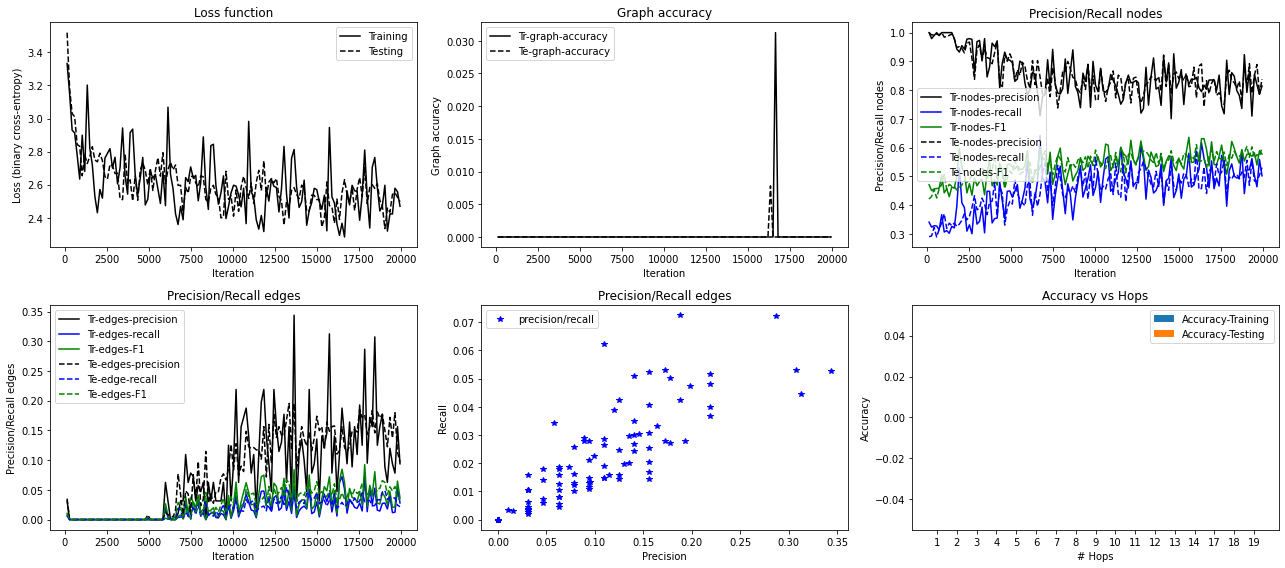

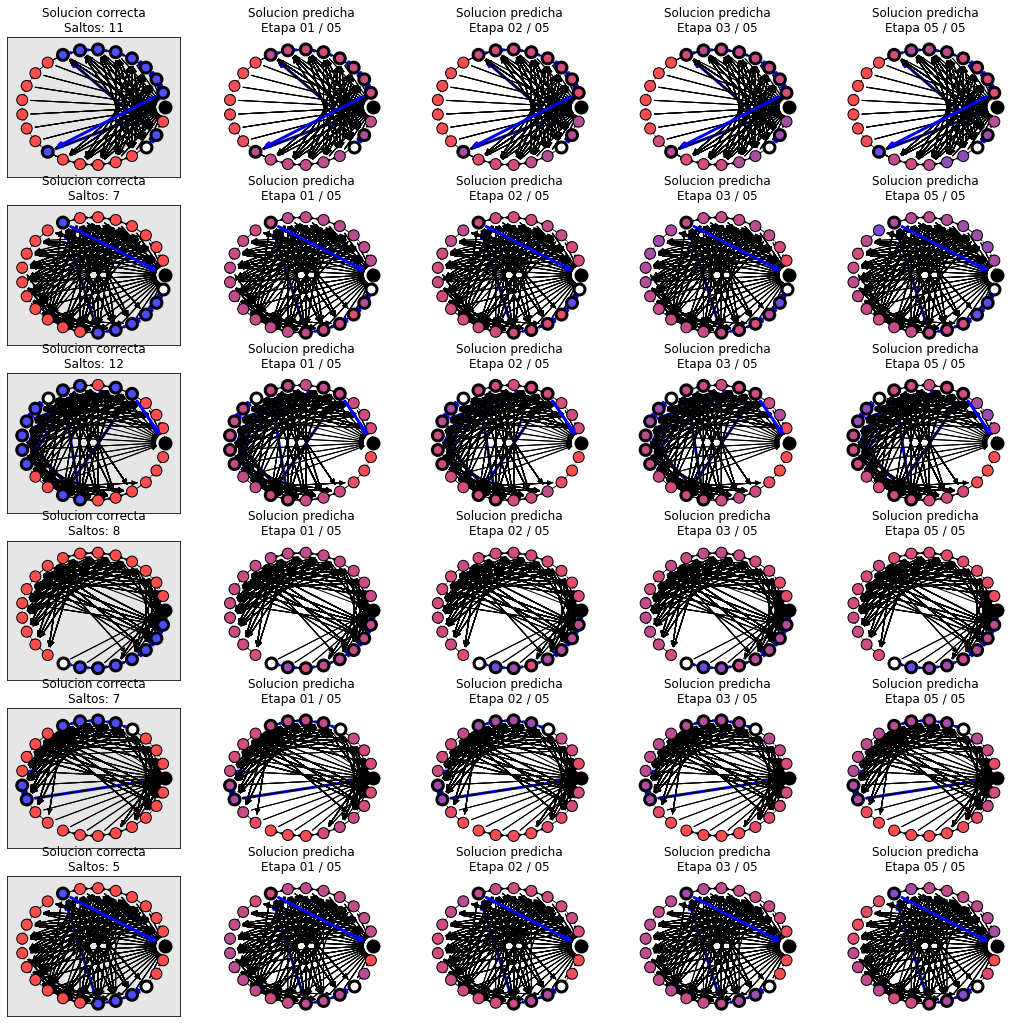

In [9]:
# Esta celda permite visualizar el resutado del entrenamiento de la celda anterior.

def softmax_prob_last_dim(x):
  e = np.exp(x)
  return e[:, -1] / np.sum(e, axis=-1)

# Figura
fig = plt.figure(1, figsize=(18, 8))
fig.clf()
x = np.array(logged_iterations)

# 1. Plot: Curvas de pérdida a lo largo del entrenamiento y del testing.
y_tr = losses_train
y_te = losses_test
ax = fig.add_subplot(2, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_te, "k--", label="Testing")
ax.set_title("Loss function")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss (binary cross-entropy)")
ax.legend()

# 2. Plot: fracción de predicciones correctas de grafos completos tanto en entrenamiento como en testing (accuracy). 
y_tr = pd.DataFrame(metrics_train)
y_te = pd.DataFrame(metrics_test)
ax = fig.add_subplot(2, 3, 2)
ax.plot(x, y_tr['accuracy_graph'], "k", label="Tr-graph-accuracy")
ax.plot(x, y_te['accuracy_graph'], "k--", label="Te-graph-accuracy")
ax.set_title("Graph accuracy")
ax.set_xlabel("Iteration")
ax.set_ylabel("Graph accuracy")
ax.legend()

# 3. Plot: precision/recall/f1 nodes
ax = fig.add_subplot(2, 3, 3)
ax.plot(x, y_tr['precision_nodes'], "k", label="Tr-nodes-precision")
ax.plot(x, y_tr['recall_nodes'], "b", label="Tr-nodes-recall")
ax.plot(x, y_tr['f1_nodes'], "g", label="Tr-nodes-F1")
ax.plot(x, y_te['precision_nodes'], "k--", label="Te-nodes-precision")
ax.plot(x, y_te['recall_nodes'], "b--", label="Te-nodes-recall")
ax.plot(x, y_te['f1_nodes'], "g--", label="Te-nodes-F1")
ax.set_title("Precision/Recall nodes")
ax.set_xlabel("Iteration")
ax.set_ylabel("Precision/Recall nodes")
ax.legend()

# 4. Plot: precision/recall/f1 edges
ax = fig.add_subplot(2, 3, 4)
ax.plot(x, y_tr['precision_edges'], "k", label="Tr-edges-precision")
ax.plot(x, y_tr['recall_edges'], "b", label="Tr-edges-recall")
ax.plot(x, y_tr['f1_edges'], "g", label="Tr-edges-F1")
ax.plot(x, y_te['precision_edges'], "k--", label="Te-edges-precision")
ax.plot(x, y_te['recall_edges'], "b--", label="Te-edge-recall")
ax.plot(x, y_te['f1_edges'], "g--", label="Te-edges-F1")
ax.set_title("Precision/Recall edges")
ax.set_xlabel("Iteration")
ax.set_ylabel("Precision/Recall edges")
ax.legend()

# 5. Plot: precision edges vs recall edges 
ax = fig.add_subplot(2, 3, 5)
ax.plot(y_tr['precision_edges'], y_tr['recall_edges'], "b*", label="precision/recall")
ax.set_title("Precision/Recall edges")
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.legend()

# 6. Plot: accuracy vs Numero de Hops
ax = fig.add_subplot(2, 3, 6)
x_tr = list(accuracyVsHops_train.keys())
y_tr = list(accuracyVsHops_train.values())
x_te = list(accuracyVsHops_test.keys())
y_te = list(accuracyVsHops_test.values())
#ax.bar(x_tr, y_tr, "b", label="Accuracy-Training")
ax.bar(range(len(x_tr)), y_tr, tick_label=x_tr, align="edge", width=-0.4, label="Accuracy-Training")
ax.bar(range(len(x_te)), y_te, tick_label=x_te, align="edge", width=0.4, label="Accuracy-Testing")
#ax.bar(x_te, y_te, "o", label="Accuracy-Testing")
ax.set_title("Accuracy vs Hops")
ax.set_xlabel("# Hops")
ax.set_ylabel("Accuracy")
ax.legend()

plt.tight_layout()


# Además de las curvas de rendimiento del entrenamiento, el ejemplo de la libraría recuerda las etiquetas de caminos más cortos a lo largo del proceso, en base a los cuales se puede imprimir y graficar la evolución de los caminos elegidos en cada grafo.
# En las gráficas de nodos, en nodo origen se imprime en blanco, el nodo destino en negro. El resto de los nodos queda en un gradiente rojo/azul que indica la certidumbre del modelo de que el nodo está fuera del camino más corto (rojo) o bien de que el mismo está dentro del camino más corto (azul).
max_graphs_to_plot = 6
num_steps_to_plot = 4
node_size = 120
min_c = 0.3
num_graphs = len(raw_targetGraphs)
targets = utils_np.graphs_tuple_to_data_dicts(test_values["target"])
step_indices = np.floor(
    np.linspace(0, num_processing_steps_test - 1,
                num_steps_to_plot)).astype(int).tolist()
outputs = list(
    zip(*(utils_np.graphs_tuple_to_data_dicts(test_values["outputs"][i])
          for i in step_indices)))
h = min(num_graphs, max_graphs_to_plot)
w = num_steps_to_plot + 1
fig = plt.figure(101, figsize=(18, h * 3))
fig.clf()
ncs = []
for j, (raw_targetGraph, target, output) in enumerate(zip(raw_targetGraphs, targets, outputs)):
  if j >= h:
    break
  pos = nx.circular_layout(raw_targetGraph)
  ground_truth = target["nodes"][:, -1]
  # Ground truth.
  iax = j * (1 + num_steps_to_plot) + 1
  ax = fig.add_subplot(h, w, iax)
  plotter = GraphPlotter(ax, raw_targetGraph, pos)
  color = {}
  for i, n in enumerate(plotter.nodes):
    color[n] = np.array([1.0 - ground_truth[i], 0.0, ground_truth[i], 1.0
                        ]) * (1.0 - min_c) + min_c
  plotter.draw_graph_with_solution(node_size=node_size, node_color=color)
  ax.set_axis_on()
  ax.set_xticks([])
  ax.set_yticks([])
  try:
    ax.set_facecolor([0.9] * 3 + [1.0])
  except AttributeError:
    ax.set_axis_bgcolor([0.9] * 3 + [1.0])
  ax.grid(None)
  ax.set_title("Solucion correcta\nSaltos: {}".format(
      plotter.solution_length))
  # Prediction.
  for k, outp in enumerate(output):
    iax = j * (1 + num_steps_to_plot) + 2 + k
    ax = fig.add_subplot(h, w, iax)
    plotter = GraphPlotter(ax, raw_targetGraph, pos)
    color = {}
    prob = softmax_prob_last_dim(outp["nodes"])
    for i, n in enumerate(plotter.nodes):
      color[n] = np.array([1.0 - prob[n], 0.0, prob[n], 1.0
                          ]) * (1.0 - min_c) + min_c
    plotter.draw_graph_with_solution(node_size=node_size, node_color=color)
    ax.set_title("Solucion predicha\nEtapa {:02d} / {:02d}".format(
        step_indices[k] + 1, step_indices[-1] + 1))

In [10]:
# Guardo los raw de los plots
with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_logged_iterations' + '.pickle', 'wb') as file:
  pickle.dump(logged_iterations, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_losses_train' + '.pickle', 'wb') as file:
  pickle.dump(losses_train, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_losses_test' + '.pickle', 'wb') as file:
  pickle.dump(losses_test, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_metrics_train' + '.pickle', 'wb') as file:
  pickle.dump(metrics_train, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_metrics_test' + '.pickle', 'wb') as file:
  pickle.dump(metrics_test, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_accuracyVsHops_train' + '.pickle', 'wb') as file:
  pickle.dump(accuracyVsHops_train, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_accuracyVsHops_test' + '.pickle', 'wb') as file:
  pickle.dump(accuracyVsHops_test, file, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# TODO List:
#  - Graficar edges por separado

# Para mejorar:
#  - Normalizar tiempos entre 0 y 1
#  - toquetear parametros de entrenamiento
#  - agregar algun feature
#  - toquetear modelo 